# Import dataset

In [1]:
import pm4py
from label_functions import *
import editdistance
from functions import *


# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

event_log = import_xes("data/Hospital_log.xes.gz")
print(type(event_log))
print(event_log)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

## Covert to log and sort based on timestamp. Convert back to dataframe to apply label function 1

In [18]:
from pm4py.objects.log.util import sorting

# Convert to event log before sorting.
log = pm4py.convert_to_event_log(event_log)
# Sort the event log in ascending order by timestamp
log_sorted = sorting.sort_timestamp(log, timestamp_key="time:timestamp", reverse_sort=False)

# Check the first trace start time to verify sorting
print(f"First trace start time: {log_sorted[0][0]['time:timestamp']}")
print(f"Last trace start time: {log_sorted[-1][0]['time:timestamp']}")

First trace start time: 2005-01-03 00:00:00+00:00
Last trace start time: 2008-03-20 00:00:00+00:00


In [19]:
# Now convert the dataframe to an event log
log_df = pm4py.convert_to_dataframe(log_sorted)
log_df.head(10)

,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Treatment code:14,case:Treatment code:15,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15
0,Radiotherapy,1,61,1e consult poliklinisch,SRTH,Section 5,410100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Radiotherapy,1,61,administratief tarief - eerste pol,SRTH,Section 5,419100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nursing ward,1,7,verlosk.-gynaec. korte kaart kosten-out,SGEH,Section 2,10107,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Obstetrics & Gynaecology clinic,1,7,echografie - genitalia interna,SGEC,Section 2,339486E,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nursing ward,1,7,1e consult poliklinisch,SGEH,Section 2,410100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Nursing ward,1,7,administratief tarief - eerste pol,SGEH,Section 2,419100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Radiotherapy,1,61,simulator - gebruik voor aanvang megavol,RATH,Section 5,390520,2005-01-24 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Radiotherapy,1,61,behandeltijd - eenheid t3 - megavolt,RATH,Section 5,390003,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Radiotherapy,1,61,teletherapie - megavolt fotonen bestrali,RATH,Section 5,390550,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2005-02-15 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Label Function 1

In [20]:
def label_function (log_df, required_activities):

    # Filter log to retain only traces with required activities
    filtered_df = pm4py.filtering.filter_event_attribute_values(
        log_df,
        attribute_key='concept:name',
        values=required_activities,
        level='case',
        retain=True,
        case_id_key='case:concept:name'
    )
    
    # Identify case IDs in the filtered DataFrame (these cases are normal)
    normal_cases = filtered_df['case:concept:name'].unique()
    
    # Add a 'deviant' column to label cases
    log_df['case:Deviant'] = log_df['case:concept:name'].apply(lambda x: 'normal' if x in normal_cases else 'deviant')
    
    return log_df


# Define required activities for this rule
required_activities_f1 = ['ca-19.9 tumormarker', 'ca-125 mbv meia']

log_df = label_function(log_df, required_activities_f1)
log_df.head(10)

,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Treatment code:15,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15,case:Deviant
0,Radiotherapy,1,61,1e consult poliklinisch,SRTH,Section 5,410100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
1,Radiotherapy,1,61,administratief tarief - eerste pol,SRTH,Section 5,419100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
2,Nursing ward,1,7,verlosk.-gynaec. korte kaart kosten-out,SGEH,Section 2,10107,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
3,Obstetrics & Gynaecology clinic,1,7,echografie - genitalia interna,SGEC,Section 2,339486E,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
4,Nursing ward,1,7,1e consult poliklinisch,SGEH,Section 2,410100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
5,Nursing ward,1,7,administratief tarief - eerste pol,SGEH,Section 2,419100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
6,Radiotherapy,1,61,simulator - gebruik voor aanvang megavol,RATH,Section 5,390520,2005-01-24 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
7,Radiotherapy,1,61,behandeltijd - eenheid t3 - megavolt,RATH,Section 5,390003,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
8,Radiotherapy,1,61,teletherapie - megavolt fotonen bestrali,RATH,Section 5,390550,2005-01-31 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant
9,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2005-02-15 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant


## Check class balance (optional)

case:Deviant
deviant    683
normal     460
Name: count, dtype: int64


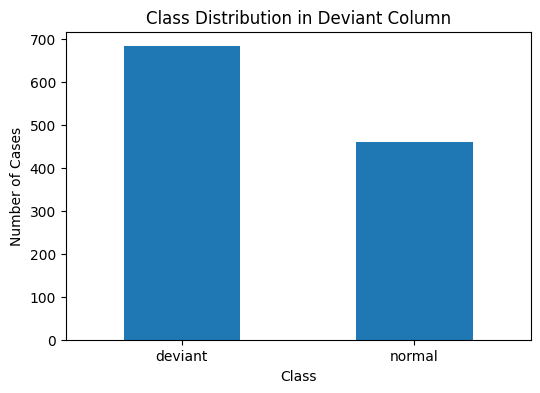

In [21]:
import matplotlib.pyplot as plt

# Count the number of normal and deviant cases
class_counts = log_df[['case:concept:name', 'case:Deviant']].drop_duplicates()['case:Deviant'].value_counts()
print (class_counts)
# Plot the class distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Deviant Column')
plt.xlabel('Class')
plt.ylabel('Number of Cases')
plt.xticks(rotation=0)
plt.show()

## Convert to log and apply train test split

In [22]:
log = pm4py.convert_to_event_log(log_df)

In [23]:
# Split cases into training and testing sets based on 80/20 split
train_log, test_log = pm4py.split_train_test(log, train_percentage=0.8)

print("Train_log size: {}".format(len(train_log)))
print("Test log size: {}".format(len(test_log)))

Train_log size: 915
Test log size: 228


# Prefix extraction (k=21 ; g=5)

In [25]:
# Extract prefix
def extract_prefixes(log, max_length=21, step_size=5):
    # Transform log to dataframe
    log_df = pm4py.convert_to_dataframe(log)
    # Store prefixes for all step sizes
    all_prefixes = []
    
    # Loop over each step size
    lengths = list(range(1, max_length + 1, step_size))  # e.g., [1, 4, 7, 10, 13, 16, 19] for g = 3
    for length in lengths:
        # Extract prefixes of specified length
        trimmed_df = pm4py.get_prefixes_from_log(log_df, length=length, case_id_key='case:concept:name')
        all_prefixes.append(trimmed_df)
        
    # Combine all prefixes into a single DataFrame
    combined_prefixes = pd.concat(all_prefixes, ignore_index=True)
    # Check the result
    print(f"Total prefixes extracted: {len(combined_prefixes)}")
    return combined_prefixes


train_prefixes_df = extract_prefixes(train_log, max_length=21, step_size=5)

train_prefixes_df

Total prefixes extracted: 40714


,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15,case:Deviant,@@index_in_trace
0,Obstetrics & Gynaecology clinic,1,7,verlosk.-gynaec. korte kaart kosten-out,SGAL,Section 2,10107,2005-03-30 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,0
1,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2006-10-06 01:00:00+00:00,complete,2007-01-05 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,0
2,Obstetrics & Gynaecology clinic,1,7,verlosk.-gynaec. jaarkaart kosten-out,SGNA,Section 2,10307,2005-05-26 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant,0
3,Nursing ward,1,7,ligdagen - alle spec.beh.kinderg.-reval.,H5ZU,Section 2,40014,2007-07-09 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,0
4,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2006-02-16 00:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40709,General Lab Clinical Chemistry,1,86,aanname laboratoriumonderzoek,CRLA,Section 4,370000,2006-06-01 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant,13
40710,General Lab Clinical Chemistry,1,86,ordertarief,CRLA,Section 4,379999,2006-06-01 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant,14
40711,Obstetrics & Gynaecology clinic,1,7,telefonisch consult,SGNA,Section 2,415100,2006-07-13 01:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant,15
40712,Obstetrics & Gynaecology clinic,1,7,vervolgconsult poliklinisch,SGNA,Section 2,411100,2007-03-19 00:00:00+00:00,complete,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deviant,16


# Sequence Encoding (not applied yet)

In [ ]:
# Convert prefixes to sequence encoding for DBSCAN
sequence_encoded_prefixes = [' '.join(map(str, prefix)) for prefix in all_prefixes]

In [ ]:

# Step 3: Compute edit distance matrix for the training set only
n_train = len(sequence_encoded_prefixes)
train_distance_matrix = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(i + 1, n_train):
        dist = edit_distance(sequence_encoded_prefixes[i], sequence_encoded_prefixes[j])
        train_distance_matrix[i, j] = dist
        train_distance_matrix[j, i] = dist  # Symmetric matrix

# Step 4: Apply DBSCAN on the training set using the specified parameters
#dbscan = DBSCAN(eps=0.125, min_samples=4, metric='precomputed')
#dbscan = DBSCAN(eps=0.15, min_samples=6, metric='precomputed')
dbscan = DBSCAN(eps=0.2, min_samples=6, metric='precomputed')
train_cluster_labels = dbscan.fit_predict(train_distance_matrix)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define columns for data attributes
X_cols = ['case:Diagnosis code', 'case:Treatment code']

# Initialize label encoders with a placeholder for unknown values
label_encoders = {col: LabelEncoder() for col in X_cols}

# Fit each encoder to the unique values in the corresponding column of the training log
for col in X_cols:
    label_encoders[col].fit(train_log[col].astype(str))  # Ensure data is treated as strings

# Define a function to safely transform data using LabelEncoder, handling unknown values
def safe_transform(encoder, value):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        # Adding the unknown label on the fly (or set it to a pre-defined value, like -1)
        return -1  # or handle as desired for unknowns




In [ ]:
def encode_data_attributes(event_log, prefixes, attributes):
    encoded_data = []
    
    # Iterate over each prefix
    for prefix in prefixes:
        # Get the last event in the current prefix
        last_event = prefix[-1]
        
        # Create a vector by safely encoding each attribute for the last event
        data_vector = [
            safe_transform(
                label_encoders[attr], 
                event_log.loc[event_log['Activity code'] == last_event, attr].values[0]
            ) 
            for attr in attributes
        ]
        
        # Add the encoded vector to the results
        encoded_data.append(data_vector)
    
    return encoded_data

In [ ]:
# Columns used for classifier training
X_cols = ['case:Diagnosis code', 'case:Treatment code']

# Define a threshold for the minimum number of samples required -- OPTIONAL -- TO IMPROVE ROBUSTNESS
min_samples_threshold = 10

# Step 5: Train a classifier for each cluster in the training set
clusters = {}
for cluster_label in np.unique(train_cluster_labels):
    if cluster_label == -1:
        continue  # Skip noise points

    # Get indices of prefixes in the current cluster
    cluster_indices = [i for i, label in enumerate(train_cluster_labels) if label == cluster_label]
    X_cluster = [encode_data_attributes(train_log, [all_prefixes.iloc[i]], X_cols)[0] for i in cluster_indices]
    y_cluster = [lf_map[all_prefixes.index[i]] for i in cluster_indices]  # Get labels for each prefix
    
    # Skip training for clusters with fewer samples than the threshold -- OPTIONAL -- TO IMPROVE ROBUSTNESS
    if len(X_cluster) < min_samples_threshold:
        print(f"Skipping small cluster {cluster_label} with {len(X_cluster)} samples.")
        continue
    
     # Print cluster size for inspection
    print(f"Cluster {cluster_label}: Size of X_cluster = {len(X_cluster)}, Size of y_cluster = {len(y_cluster)}")
    

    # Check if the cluster size is too small
    #if len(X_cluster) < 5:
        #print(f"Warning: Cluster {cluster_label} has very few samples ({len(X_cluster)}). Consider adjusting DBSCAN parameters.")
    
    # Train decision tree classifier for the current cluster
    clf = DecisionTreeClassifier()
    clf.fit(X_cluster, y_cluster)
    clusters[cluster_label] = clf  # Store classifier by cluster label

In [ ]:
# Step 6: Define functions for finding the closest cluster and for reliable prediction

def find_closest_cluster(running_trace, train_prefixes, train_cluster_labels):
    # Convert running trace to sequence encoding
    running_sequence = ' '.join(map(str, running_trace))
    # Calculate edit distances between the running trace and each training prefix
    distances = [edit_distance(running_sequence, train_seq) for train_seq in train_prefixes]
    # Get the closest training prefix and its corresponding cluster label
    closest_idx = np.argmin(distances)
    closest_cluster = train_cluster_labels[closest_idx]
    return closest_cluster, closest_idx

def predict_with_reliability(clf, X_test, thresholds=[0.5, 0.6], min_class_support=3):
    probs = clf.predict_proba([X_test])[0]
    predicted_class = np.argmax(probs)
    class_support = np.sum(clf.classes_ == predicted_class)
    class_prob = probs[predicted_class]
    if class_support >= min_class_support and any(class_prob >= t for t in thresholds):
        return predicted_class, class_prob
    return None, None

In [ ]:

# Step 7: Replay each test trace for prediction
for test_trace in test_log.groupby('case:concept:name')['Activity code'].apply(list):
    reliable_prediction = False
    # Incrementally generate prefixes every 5 events (replay logic)
    for i in range(1, len(test_trace) + 1, 5):  # Replay every 5 events
        current_prefix = test_trace[:i]
        
        # Find the closest cluster using minimum edit distance
        closest_cluster, closest_idx = find_closest_cluster(current_prefix, sequence_encoded_prefixes, train_cluster_labels)
        
        if closest_cluster == -1:
            continue  # Skip if the closest cluster is noise

        clf = clusters.get(closest_cluster)
        if clf:
            X_test = encode_data_attributes(test_log, [current_prefix], X_cols)[0]
            predicted_class, confidence = predict_with_reliability(clf, X_test)
            print(predicted_class,confidence)
            if predicted_class is not None:
                print(f"Reliable prediction achieved: {predicted_class} with confidence {confidence}")
                reliable_prediction = True
                break  # Stop if a reliable prediction is made
    
    if not reliable_prediction:
        print("Prediction failure: No reliable prediction achieved by end of trace.")
